# Proyek Pertama : Membuat Model NLP dengan TensorFlow
- Nama: Jeremy Ethan Novriawan
- Id Dicoding: jeremyethann

Data dari https://www.kaggle.com/datasets/momo12341234/cyberbully-detection-dataset

# Library

In [1]:
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import pandas as pd
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import Data

In [2]:
df = pd.read_csv('cb_multi_labeled_balanced.csv')
df.head()

,text,label
0,@ZubearSays Any real nigga isn't letting this ...,ethnicity/race
1,@MoradoSkittle @prolifejewess @DAConsult @Kell...,not_cyberbullying
2,"the only thing i wish, i wish a nigga would",ethnicity/race
3,You saudias are not friends of Muslim idiots c...,religion
4,@JaydenT2399 @TractorLaw @holmes_gael @erconge...,religion


In [3]:
# Melihat ukuran data, 99990 sampel, melebihi 2000 sampel
df.shape

(99990, 2)

## Eksplorasi Data

In [4]:
# Mencari tahu persebaran label untuk melihat distribusi kategori
df['label'].value_counts()

not_cyberbullying    50000
ethnicity/race       17000
gender/sexual        17000
religion             15990
Name: label, dtype: int64

In [5]:
# melihat jenis label yang ada, terdapat 4 jenis kelas, melebihi 3 kelas
df['label'].unique()

array(['ethnicity/race', 'not_cyberbullying', 'religion', 'gender/sexual'],
      dtype=object)

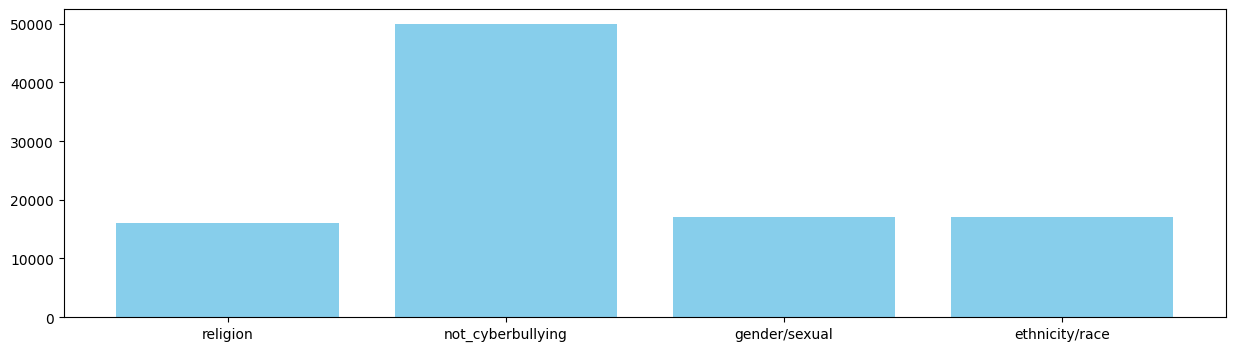

In [6]:
# Hitung jumlah nilai dan urutkan berdasarkan jumlahnya dengan urutan descending
value_counts = df['label'].value_counts().reset_index()
value_counts.columns = ['label', 'Count']
sorted_value_counts = value_counts.sort_values(by='label', ascending=False)


# Buat bar chart
plt.figure(figsize=(15, 4))
plt.bar(sorted_value_counts['label'], sorted_value_counts['Count'], color='skyblue')
plt.show()

In [7]:
# Buat label dummies untuk setiap kategori
category = pd.get_dummies(df.label)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='label')
df_baru.head()

,text,ethnicity/race,gender/sexual,not_cyberbullying,religion
0,@ZubearSays Any real nigga isn't letting this ...,1,0,0,0
1,@MoradoSkittle @prolifejewess @DAConsult @Kell...,0,0,1,0
2,"the only thing i wish, i wish a nigga would",1,0,0,0
3,You saudias are not friends of Muslim idiots c...,0,0,0,1
4,@JaydenT2399 @TractorLaw @holmes_gael @erconge...,0,0,0,1


## Stop word

In [8]:
stop_words = set(stopwords.words("english"))

# Membuat praproses untuk stopwords
def preprocess_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [w for w in word_tokens if w.lower() not in stop_words]
    return ' '.join(filtered_text)

# Mengaplikasikan fungsi yang telah dibuat untuk menghapus stopwords
df_baru['text'] = df_baru['text'].apply(preprocess_stopwords)
df_baru.head()

,text,ethnicity/race,gender/sexual,not_cyberbullying,religion
0,@ ZubearSays real nigga n't letting happen .,1,0,0,0
1,@ MoradoSkittle @ prolifejewess @ DAConsult @ ...,0,0,1,0
2,"thing wish , wish nigga would",1,0,0,0
3,saudias friends Muslim idiots cheapless people,0,0,0,1
4,@ JaydenT2399 @ TractorLaw @ holmes_gael @ erc...,0,0,0,1


## Punctuation

In [9]:
# praproses untuk tanda baca
tokenizer = RegexpTokenizer(r"\w+")

# Mengaplikasikan penghapusan tanda baca
df_baru['text'] = df_baru['text'].apply(lambda x: ' '.join(tokenizer.tokenize(x)))
df_baru.head()

,text,ethnicity/race,gender/sexual,not_cyberbullying,religion
0,ZubearSays real nigga n t letting happen,1,0,0,0
1,MoradoSkittle prolifejewess DAConsult KellyYod...,0,0,1,0
2,thing wish wish nigga would,1,0,0,0
3,saudias friends Muslim idiots cheapless people,0,0,0,1
4,JaydenT2399 TractorLaw holmes_gael erconger Ac...,0,0,0,1


In [10]:
# Menggambil values
text = df_baru['text'].values
label = df_baru[df['label'].unique()].values

# Membagi data

In [11]:
# Membagi data menjadi 80% training dan 20% test
text_latih, text_test, label_latih, label_test = train_test_split(
    text, label, test_size=0.20, stratify=label)
# stratify digunakan agar pembagian kategori sama rata

## Jumlah data setelah dibagi

In [12]:
# ukuran text_latih, text_test, label_latih, label_test untuk menunjukkan data validasi 20%
print("Ukuran data/text latih:", len(text_latih))
print("Ukuran data/text test:", len(text_test))
print("Ukuran label latih:", len(label_latih))
print("Ukuran label test:", len(label_test))
print("Data validasi berukuran", len(text_test)/(len(text_latih)+len(text_test))*100, "% dari data total")

Ukuran data/text latih: 79992
Ukuran data/text test: 19998
Ukuran label latih: 79992
Ukuran label test: 19998
Data validasi berukuran 20.0 % dari data total


# Tokenizing and Embedding

In [13]:
# Melakukan tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='UNK')
tokenizer.fit_on_texts(text_latih)
# text_test tidak dibuat tokenizer agar tidak overfitting

# Membuat sekuens
sekuens_latih = tokenizer.texts_to_sequences(text_latih)
sekuens_test = tokenizer.texts_to_sequences(text_test)

# Melakukan padding
padded_latih = pad_sequences(sekuens_latih,
                             padding='post',
                             maxlen=25,
                             truncating='post')
padded_test = pad_sequences(sekuens_test,
                             padding='post',
                             maxlen=25,
                             truncating='post')

# Model

In [14]:
# Pembuatan model dengan Sequential, Embedding, LSTM, dan dropout
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Menentukan optimizer, loss, dan metrics
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [15]:
# Jumlah epochs
num_epochs = 50

# Kriteria pemberhentian awal dengan memperhatikan val_accuracy dengan kesabaran 10
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Menyimpan pada history untuk plotting loss dan akurasi pada training dan validasi
history = model.fit(padded_latih, label_latih, epochs=num_epochs,
                    validation_data=(padded_test, label_test),
                    callbacks=[early_stopping], verbose=2)

Epoch 1/50
2500/2500 - 45s - loss: 0.2822 - accuracy: 0.8743 - val_loss: 0.0794 - val_accuracy: 0.9772 - 45s/epoch - 18ms/step
Epoch 2/50
2500/2500 - 17s - loss: 0.0548 - accuracy: 0.9848 - val_loss: 0.0418 - val_accuracy: 0.9894 - 17s/epoch - 7ms/step
Epoch 3/50
2500/2500 - 17s - loss: 0.0302 - accuracy: 0.9922 - val_loss: 0.0425 - val_accuracy: 0.9915 - 17s/epoch - 7ms/step
Epoch 4/50
2500/2500 - 16s - loss: 0.0213 - accuracy: 0.9950 - val_loss: 0.0423 - val_accuracy: 0.9909 - 16s/epoch - 7ms/step
Epoch 5/50
2500/2500 - 16s - loss: 0.0163 - accuracy: 0.9962 - val_loss: 0.0415 - val_accuracy: 0.9915 - 16s/epoch - 6ms/step
Epoch 6/50
2500/2500 - 16s - loss: 0.0107 - accuracy: 0.9975 - val_loss: 0.0538 - val_accuracy: 0.9918 - 16s/epoch - 6ms/step
Epoch 7/50
2500/2500 - 16s - loss: 0.0097 - accuracy: 0.9977 - val_loss: 0.0600 - val_accuracy: 0.9906 - 16s/epoch - 7ms/step
Epoch 8/50
2500/2500 - 17s - loss: 0.0078 - accuracy: 0.9983 - val_loss: 0.0808 - val_accuracy: 0.9881 - 17s/epoch - 

# Plot akurasi dan loss tiap epoch

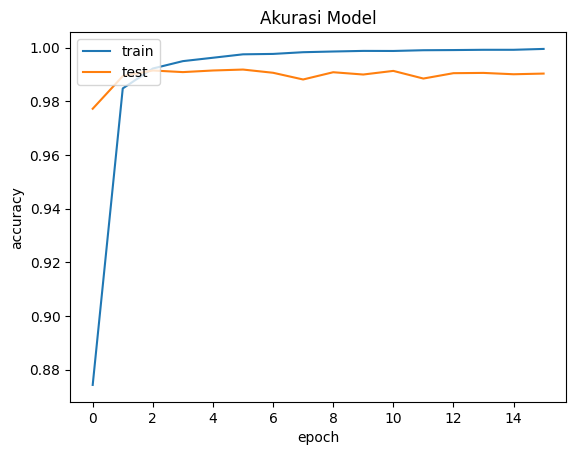

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

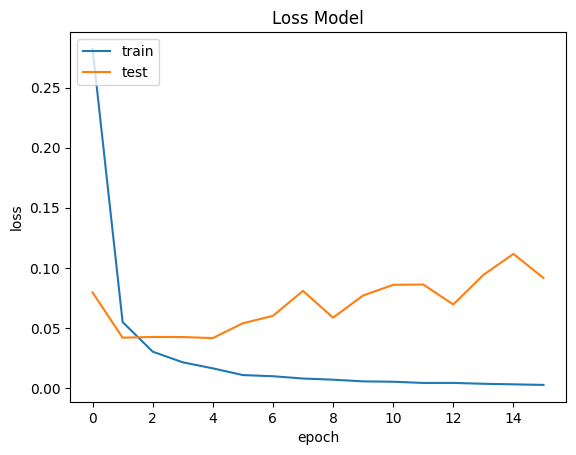

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()